In [0]:
from pyspark.sql import functions as F
from graphframes import GraphFrame


In [0]:
from pyspark.sql import functions as F
from graphframes.lib import AggregateMessages as AM

# 1. Numero di nodi e archi
num_vertices = graph.vertices.count()
num_edges = graph.edges.count()

print("Number of vertices:", num_vertices)
print("Number of edges:", num_edges)


# 2. Connected Components (per trovare la WCC più grande)
components = graph.connectedComponents()
components.cache()

wcc_sizes = components.groupBy("component").count()
largest_wcc = wcc_sizes.orderBy(F.desc("count")).first()

print("\nLargest Weakly Connected Component:")
print("Component ID:", largest_wcc["component"])
print("Size:", largest_wcc["count"])


# 3. Fraction of nodes inside largest WCC
fraction_wcc = largest_wcc["count"] / num_vertices
print("Fraction of all vertices in largest WCC:", fraction_wcc)


# 4. Approximate Diameter (GraphFrames BFS non è praticabile su milioni di nodi → utilizziamo landmark-based BFS)
import random

sample_nodes = graph.vertices.sample(False, 0.0001).limit(10).select("id").rdd.flatMap(lambda x: x).collect()

max_distances = []

for s in sample_nodes:
    # BFS from sample node (approximate diameter)
    bfs_df = graph.bfs(
        fromExpr=f"id = {s}",
        toExpr=None,
        maxPathLength=10
    )
    if bfs_df.count() > 0:
        # compute path length
        lengths = bfs_df.rdd.map(lambda row: sum([1 for k in row.asDict().keys() if k.startswith("e")])).collect()
        max_distances.append(max(lengths))

approx_diameter = max(max_distances) if max_distances else None
print("\nApproximate Diameter:", approx_diameter)


# 5. Local Clustering Coefficient (GraphFrames motif trick)
triangles = graph.find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(a)")
num_triangles = triangles.count()

print("\nNumber of triangles:", num_triangles)

# clustering coefficient approx = (3 * #triangles) / #wedges
# wedges = triples (a-b-c) where b connects to both a and c

wedges = graph.find("(a)-[]->(b); (c)-[]->(b)").count()

clustering_coeff = (3 * num_triangles) / wedges if wedges > 0 else 0
print("Approximate clustering coefficient:", clustering_coeff)



Number of vertices: 1965206
Number of edges: 11066428


---------------------------------------------------------------------------
Py4JJavaError Traceback (most recent call last)
File , line 13
 9 print("Number of edges:", num_edges)
 12 # 2. Connected Components (per trovare la WCC più grande)
---> 13 components = graph.connectedComponents()
 14 components.cache()
 16 wcc_sizes = components.groupBy("component").count()

File /databricks/jars/spark--maven-trees--ml--17.x--graphframes--org.graphframes--graphframes_2.13--org.graphframes__graphframes_2.13__0.8.4-db1-spark3.5.jar/graphframes/graphframe.py:345, in GraphFrame.connectedComponents(self, algorithm, checkpointInterval, broadcastThreshold, optStartIter, intermediateStorageLevel, sparsityThreshold)
 316 """
 317 Computes the connected components of the graph.
 318 
 (...)
 335 :return: DataFrame with new vertices column "component"
 336 """
 337 javaIntermediateStorageLevel = self._sc._getJavaStorageLevel(intermediateStorageLevel)
 338 jdf = self._jvm_graph.connectedComponents() \
 339 .setAlgorithm(algorithm) \
 340 .setCheckpointInterval(checkpointInterval) \
 341 .setBroadcastThreshold(broadcastThreshold) \
 342 .setOptStartIter(optStartIter) \
 343 .setIntermediateStorageLevel(javaIntermediateStorageLevel) \
 344 .setSparsityThreshold(sparsityThreshold) \
--> 345 .run()
 346 return DataFrame(jdf, self._spark)

File /databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/java_gateway.py:1362, in JavaMember.__call__(self, *args)
 1356 command = proto.CALL_COMMAND_NAME +\
 1357 self.command_header +\
 1358 args_command +\
 1359 proto.END_COMMAND_PART
 1361 answer = self.gateway_client.send_command(command)
-> 1362 return_value = get_return_value(
 1363 answer, self.gateway_client, self.target_id, self.name)
 1365 for temp_arg in temp_args:
 1366 if hasattr(temp_arg, "_detach"):

File /databricks/spark/python/pyspark/errors/exceptions/captured.py:304, in capture_sql_exception. .deco(*a, **kw)
 301 from py4j.protocol import Py4JJavaError
 303 try:
--> 304 return f(*a, **kw)
 305 except Py4JJavaError as e:
 306 converted = convert_exception(e.java_exception)

File /databricks/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/protocol.py:327, in get_return_value(answer, gateway_client, target_id, name)
 325 value = OUTPUT_CONVERTER[type](answer[2:], gateway_client)
 326 if answer[1] == REFERENCE_TYPE:
--> 327 raise Py4JJavaError(
 328 "An error occurred while calling {0}{1}{2}.\n".
 329 format(target_id, ".", name), value)
 330 else:
 331 raise Py4JError(
 332 "An error occurred while calling {0}{1}{2}. Trace:\n{3}\n".
 333 format(target_id, ".", name, value))

Py4JJavaError: An error occurred while calling o765.run.
: java.io.IOException: Checkpoint directory is not set. Please set it first using sc.setCheckpointDir().
	at org.graphframes.lib.ConnectedComponents$.$anonfun$run$5(ConnectedComponents.scala:451)
	at scala.Option.getOrElse(Option.scala:201)
	at org.graphframes.lib.ConnectedComponents$.$anonfun$run$1(ConnectedComponents.scala:450)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:323)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:323)
	at org.apache.spark.ml.MLlibHelper$.instrumented(MLlibHelper.scala:14)
	at org.graphframes.lib.ConnectedComponents$.org$graphframes$lib$ConnectedComponents$$run(ConnectedComponents.scala:426)
	at org.graphframes.lib.ConnectedComponents.run(ConnectedComponents.scala:232)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:397)
	at py4j.Gateway.invoke

In [0]:
from pyspark.sql import functions as F
from graphframes import GraphFrame

# ============================
# 1. LETTURA E COSTRUZIONE GRAFO
# ============================

# Leggo la tabella creata da roadNet-CA.txt
raw = (
    spark.read.table("default.road_net_ca")
    .filter(~F.col("value").startswith("#"))
)

# Edge list come nel file (diretta: contiene già u->v e v->u)
edges_file = raw.select(
    F.split(F.col("value"), r"\s+").getItem(0).cast("long").alias("src"),
    F.split(F.col("value"), r"\s+").getItem(1).cast("long").alias("dst")
)

# Edges "undirected" in stile SNAP (ogni strada una sola volta)
edges_undirected = (
    edges_file
    .withColumn("u", F.least("src", "dst"))
    .withColumn("v", F.greatest("src", "dst"))
    .select("u", "v")
    .dropDuplicates()
    .withColumnRenamed("u", "src")
    .withColumnRenamed("v", "dst")
)

# Vertici (incroci)
vertices = (
    edges_undirected.select(F.col("src").alias("id"))
    .union(edges_undirected.select(F.col("dst").alias("id")))
    .distinct()
)

# Per GraphFrames creo una versione bidirezionale degli archi
edges_dir = edges_undirected.unionByName(
    edges_undirected.select(
        F.col("dst").alias("src"),
        F.col("src").alias("dst")
    )
)

graph = GraphFrame(vertices, edges_dir)

# ============================
# 2. DATASET STATISTICS BASE
# ============================

num_vertices = vertices.count()
num_edges_undirected = edges_undirected.count()

print("=== BASIC DATASET STATISTICS ===")
print("Number of vertices (should be 1,965,206):", num_vertices)
print("Number of undirected edges (should be 2,766,607):", num_edges_undirected)

# ============================
# 3. LARGEST WEAKLY CONNECTED COMPONENT
# ============================

spark.sparkContext.setCheckpointDir("/tmp/graphframes-checkpoints")

components = graph.connectedComponents()
components.cache()

wcc_sizes = components.groupBy("component").count()
largest_wcc = wcc_sizes.orderBy(F.desc("count")).first()

wcc_vertex_count = largest_wcc["count"]
fraction_wcc = wcc_vertex_count / num_vertices

print("\n=== LARGEST WEAKLY CONNECTED COMPONENT ===")
print("Component ID:", largest_wcc["component"])
print("Nodes in largest WCC:", wcc_vertex_count)
print("Fraction of all vertices in largest WCC:", fraction_wcc)

# Edges nella largest WCC: entrambi gli endpoint nella componente
wcc_vertices = components.filter(
    F.col("component") == largest_wcc["component"]
).select("id").distinct()

edges_wcc = (
    edges_undirected.alias("e")
    .join(wcc_vertices.alias("v1"), F.col("e.src") == F.col("v1.id"))
    .join(wcc_vertices.alias("v2"), F.col("e.dst") == F.col("v2.id"))
)

edges_wcc_count = edges_wcc.count()
fraction_edges_wcc = edges_wcc_count / num_edges_undirected

print("Edges in largest WCC:", edges_wcc_count)
print("Fraction of all edges in largest WCC:", fraction_edges_wcc)

# ============================
# 4. GRAPH MOTIFS: TRIANGLES
# ============================

# Triangoli: (a,b,c) con a<b<c per evitare duplicati
triangles_df = graph.find(
    "(a)-[]->(b); (b)-[]->(c); (c)-[]->(a)"
).filter("a.id < b.id and b.id < c.id")

num_triangles = triangles_df.count()

print("\n=== GRAPH MOTIFS: TRIANGLES ===")
print("Number of triangles (SNAP: 120676):", num_triangles)

# ============================
# 5. GRAPH MOTIFS: WEDGES & CLUSTERING COEFFICIENT
# ============================

# Grado per ogni nodo usando gli edges undirected
deg_df = (
    edges_undirected.select(F.col("src").alias("id"))
    .union(edges_undirected.select(F.col("dst").alias("id")))
    .groupBy("id")
    .count()
    .withColumnRenamed("count", "deg")
)

# Numero totale di wedges: somma su tutti i nodi di C(deg, 2) = deg*(deg-1)/2
wedges_df = deg_df.withColumn(
    "wedges",
    (F.col("deg") * (F.col("deg") - 1)) / 2
)

wedges = wedges_df.agg(F.sum("wedges")).first()[0]

clustering_coeff = (3 * num_triangles) / wedges if wedges and wedges > 0 else 0.0

print("\n=== WEDGES & CLUSTERING COEFFICIENT ===")
print("Number of wedges (open triads):", wedges)
print("Approximate clustering coefficient (SNAP ~ 0.0464):", clustering_coeff)

# ============================
# 6. (OPZIONALE) MOSTRA A SCHERMO VERTICI E ARCHI
# ============================

# display(vertices)
# display(edges_undirected)


=== BASIC DATASET STATISTICS ===
Number of vertices (should be 1,965,206): 1965206
Number of undirected edges (should be 2,766,607): 2766607

=== LARGEST WEAKLY CONNECTED COMPONENT ===
Component ID: 0
Nodes in largest WCC: 1957027
Fraction of all vertices in largest WCC: 0.9958380953447119
Edges in largest WCC: 2760388
Fraction of all edges in largest WCC: 0.9977521201963271

=== GRAPH MOTIFS: TRIANGLES ===
Number of triangles (SNAP: 120676): 120676

=== WEDGES & CLUSTERING COEFFICIENT ===
Number of wedges (open triads): 5995090.0
Approximate clustering coefficient (SNAP ~ 0.0464): 0.06038741703627468


Loading graph from roadNet-CA.txt...
Data loaded. Head:
   FromNodeId  ToNodeId
0           0         1
1           0         2
2           0       469
3           1         0
4           1         6
Graph created.
Number of nodes: 1965206
Number of edges: 5533214
Density: 1.4327206657979522e-06
Calculating degree distribution...
Saved degree_distribution.png
Analyzing connectivity...
Number of weakly connected components: 2638
Size of largest weakly connected component: 1957027
Number of strongly connected components: 2638
Size of largest strongly connected component: 1957027
Calculating average clustering coefficient (on undirected version for speed)...
Average Clustering Coefficient (Undirected): 0.04637027007478248
Visualizing a subgraph...
Saved subgraph_visualization.png
EDA completed.


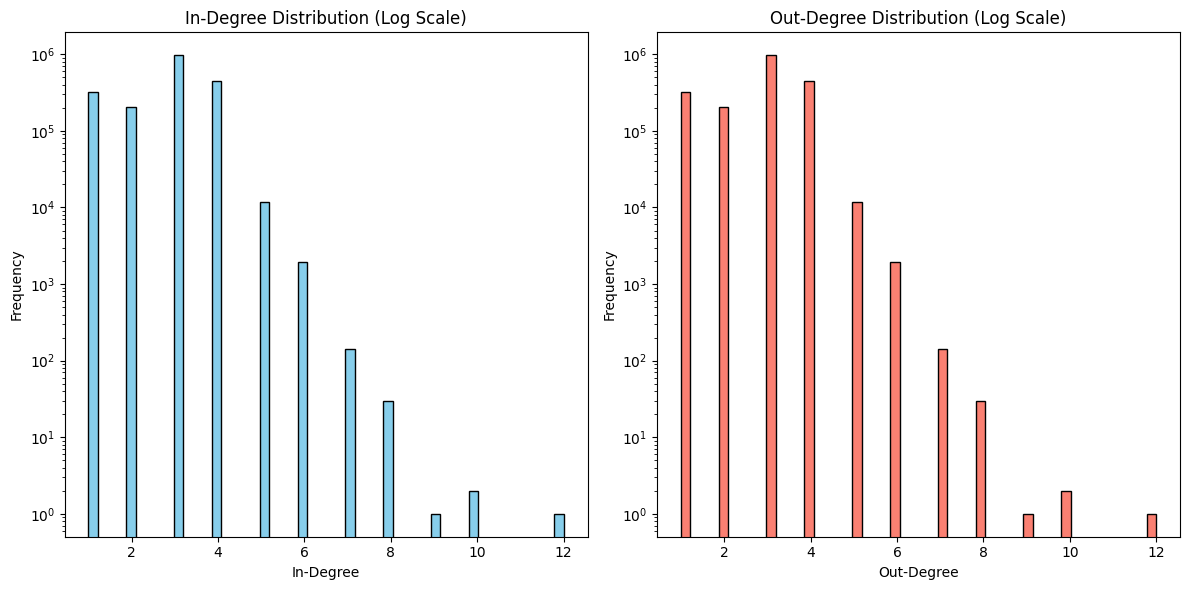

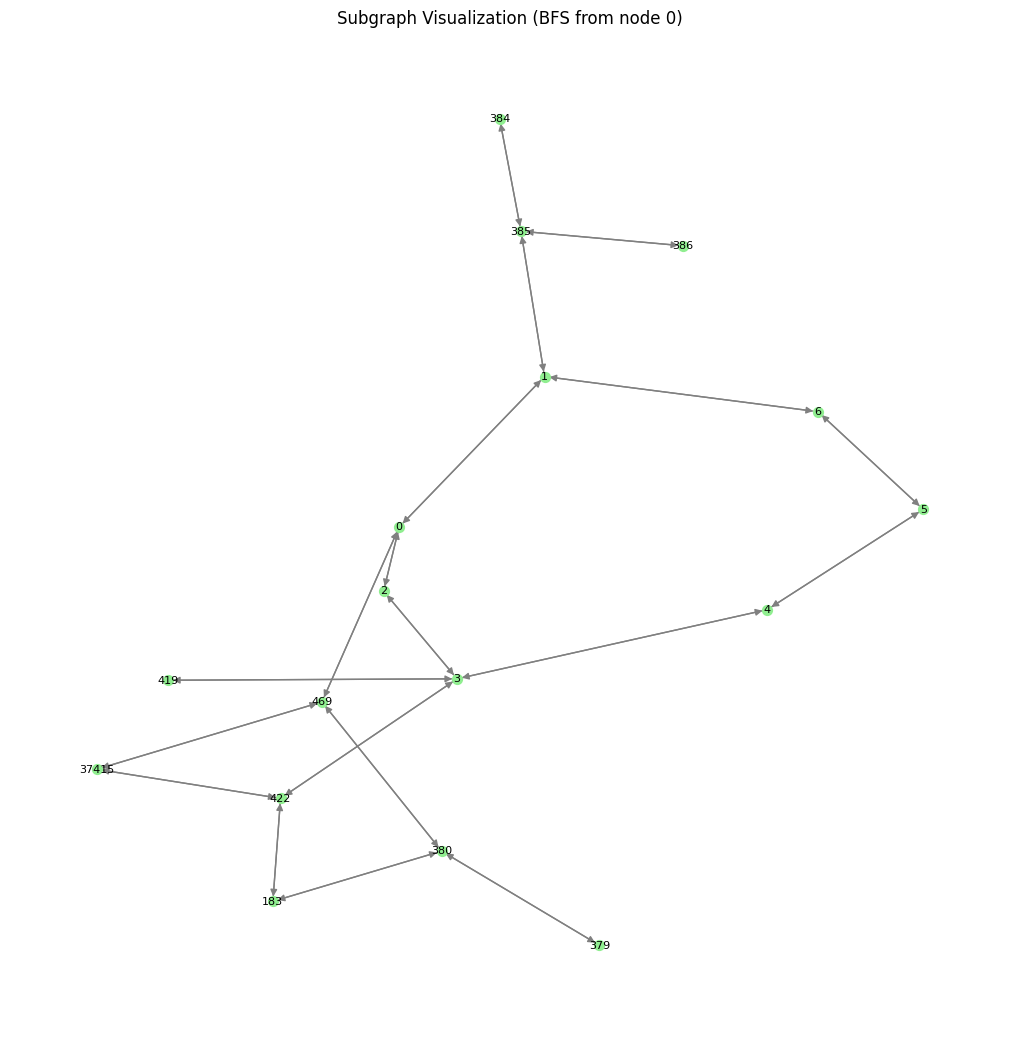

In [0]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# File path
file_path = 'roadNet-CA.txt'

print(f"Loading graph from {file_path}...")

# Read the file using pandas for efficiency
# Skip comments rows
try:
    df = pd.read_csv(file_path, sep='\t', comment='#', names=['FromNodeId', 'ToNodeId'])
except Exception as e:
    print(f"Error reading with tab separator, trying whitespace: {e}")
    df = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=['FromNodeId', 'ToNodeId'])

print(f"Data loaded. Head:\n{df.head()}")

# Create a directed graph
G = nx.from_pandas_edgelist(df, 'FromNodeId', 'ToNodeId', create_using=nx.DiGraph())

print("Graph created.")
# print(nx.info(G))

# Basic Statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density: {density}")

# Degree Distribution
print("Calculating degree distribution...")
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

# Plot Degree Distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, log=True, color='skyblue', edgecolor='black')
plt.title('In-Degree Distribution (Log Scale)')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, log=True, color='salmon', edgecolor='black')
plt.title('Out-Degree Distribution (Log Scale)')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('degree_distribution.png')
print("Saved degree_distribution.png")

# Connectivity
print("Analyzing connectivity...")
# Weakly connected components
num_weakly_connected = nx.number_weakly_connected_components(G)
print(f"Number of weakly connected components: {num_weakly_connected}")

largest_wcc = max(nx.weakly_connected_components(G), key=len)
print(f"Size of largest weakly connected component: {len(largest_wcc)}")

# Strongly connected components
num_strongly_connected = nx.number_strongly_connected_components(G)
print(f"Number of strongly connected components: {num_strongly_connected}")

largest_scc = max(nx.strongly_connected_components(G), key=len)
print(f"Size of largest strongly connected component: {len(largest_scc)}")

# Clustering Coefficient (Approximate or on a subgraph if too slow)
# For large graphs, average clustering can be slow. We'll try it on the undirected version for simplicity as it's common for road networks
print("Calculating average clustering coefficient (on undirected version for speed)...")
G_undirected = G.to_undirected()
avg_clustering = nx.average_clustering(G_undirected)
print(f"Average Clustering Coefficient (Undirected): {avg_clustering}")

# Visualize a small subgraph
print("Visualizing a subgraph...")
# Take a random node and its neighbors (BFS for a few steps)
start_node = list(G.nodes())[0]
subgraph_nodes = list(nx.bfs_tree(G, start_node, depth_limit=3).nodes())
if len(subgraph_nodes) > 100:
    subgraph_nodes = subgraph_nodes[:100]

subgraph = G.subgraph(subgraph_nodes)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_size=50, node_color='lightgreen', edge_color='gray', arrowsize=10, font_size=8)
plt.title(f'Subgraph Visualization (BFS from node {start_node})')
plt.savefig('subgraph_visualization.png')
print("Saved subgraph_visualization.png")

print("EDA completed.")

In [0]:
raw_edges = (
    spark.read.table("default.road_net_ca")
    .filter(~F.col("value").startswith("#"))
    .select(
        F.split(
            F.col("value"),
            r"\s+"
        ).alias("parts")
    )
)

edges = (
    raw_edges
    .select(
        F.col("parts")[0].cast("long").alias("src"),
        F.col("parts")[1].cast("long").alias("dst")
    )
)

edges_undir = edges.unionByName(
    edges.select(
        F.col("dst").alias("src"),
        F.col("src").alias("dst")
    )
)

vertices = (
    edges_undir
    .select(F.col("src").alias("id"))
    .union(
        edges_undir.select(F.col("dst").alias("id"))
    )
    .distinct()
)

graph = GraphFrame(vertices, edges_undir)

display(graph.vertices)
display(graph.edges)

id
26
29
474
10156
2250
31944
964
1677
1697
1806


src,dst
0,1
0,2
0,469
1,0
1,6
1,385
2,0
2,3
469,0
469,380


In [0]:
# TRIANGLE MOTIFS: (a)–(b)–(c)–(a)
triangles = graph.find("(a)-[ab]->(b); (b)-[bc]->(c); (c)-[ca]->(a)")

print("Number of triangle motifs (road loops):", triangles.count())

# mostra qualche esempio di triangolo
triangles.select("a.id", "b.id", "c.id").show(20, truncate=False)


Number of triangle motifs (road loops): 5792448
+-------+-------+-------+
|id     |id     |id     |
+-------+-------+-------+
|542717 |542559 |542560 |
|542717 |542559 |542560 |
|1853609|1855625|1853608|
|1853609|1855625|1853608|
|1853609|1855625|1853608|
|1853609|1855625|1853608|
|460509 |460510 |460511 |
|460509 |460510 |460511 |
|460509 |460510 |460511 |
|460509 |460510 |460511 |
|542717 |542559 |542560 |
|542717 |542559 |542560 |
|853998 |853992 |853995 |
|853998 |853992 |853995 |
|853998 |853992 |853995 |
|853998 |853992 |853995 |
|1841012|1841013|1840923|
|1841012|1841013|1840923|
|1841012|1841013|1840923|
|1841012|1841013|1840923|
+-------+-------+-------+
only showing top 20 rows


In [0]:
# Tutti i percorsi A -> B -> C (due archi)
two_step = graph.find("(a)-[ab]->(b); (b)-[bc]->(c)") \
                .filter("a.id != c.id")

print("Number of A-B-C paths (including cases where A-C esiste):", two_step.count())
two_step.select("a.id", "b.id", "c.id").show(10, truncate=False)


Number of A-B-C paths (including cases where A-C esiste): 47960720
+-------+-------+-------+
|id     |id     |id     |
+-------+-------+-------+
|1214795|1214796|1214786|
|140578 |144705 |125620 |
|600767 |600768 |600757 |
|1115399|1115381|1115291|
|214626 |214618 |214619 |
|1009432|1009434|1009425|
|1105077|1105055|1105030|
|1009433|1009434|1009425|
|1115382|1115381|1115291|
|1227592|1227591|1227590|
+-------+-------+-------+
only showing top 10 rows


In [0]:
from pyspark.sql import functions as F

two_step_no_direct = (
    two_step.alias("mot")
    .join(
        edges_undir.alias("e"),
        (F.col("e.src") == F.col("mot.a.id")) &
        (F.col("e.dst") == F.col("mot.c.id")),
        how="left_anti"   # tieni solo se NON trovi edge A->C
    )
)

print("Number of open wedges (A-B-C but NOT A-C):", two_step_no_direct.count())
two_step_no_direct.select("mot.a.id", "mot.b.id", "mot.c.id").show(10, truncate=False)


Number of open wedges (A-B-C but NOT A-C): 45064496
+-------+-------+-------+
|id     |id     |id     |
+-------+-------+-------+
|1529598|1529596|1529590|
|1529598|1529596|1529590|
|1529598|1529596|1529590|
|1529598|1529596|1529590|
|1292271|1267488|1267487|
|1292271|1267488|1267487|
|1292271|1267488|1267487|
|1292271|1267488|1267487|
|1902691|1902692|1904456|
|1902691|1902692|1904456|
+-------+-------+-------+
only showing top 10 rows


In [0]:
spark.sparkContext.setCheckpointDir("/tmp/graphframes-checkpoints")

components = graph.connectedComponents()
components.cache()

DataFrame[id: bigint, component: bigint]

In [0]:
from pyspark.sql import functions as F
from graphframes.lib import AggregateMessages as AM

# 1. Numero di nodi e archi
num_vertices = graph.vertices.count()
num_edges = graph.edges.count()

print("Number of vertices:", num_vertices)
print("Number of edges:", num_edges)

# 2. Connected Components (per trovare la WCC più grande)

spark.sparkContext.setCheckpointDir("/tmp/graphframes-checkpoints")

# Ora puoi calcolare le connected components
components = graph.connectedComponents()
components.cache()

wcc_sizes = components.groupBy("component").count()
largest_wcc = wcc_sizes.orderBy(F.desc("count")).first()

print("\nLargest Weakly Connected Component:")
print("Component ID:", largest_wcc["component"])
print("Size:", largest_wcc["count"])


# 3. Fraction of nodes inside largest WCC
fraction_wcc = largest_wcc["count"] / num_vertices
print("Fraction of all vertices in largest WCC:", fraction_wcc)


# 4. Approximate Diameter (GraphFrames BFS non è praticabile su milioni di nodi → utilizziamo landmark-based BFS)
import random

sample_nodes = graph.vertices.sample(False, 0.0001).limit(10).select("id").rdd.flatMap(lambda x: x).collect()

max_distances = []

for s in sample_nodes:
    # BFS from sample node (approximate diameter)
    bfs_df = graph.bfs(
        fromExpr=f"id = {s}",
        toExpr=None,
        maxPathLength=10
    )
    if bfs_df.count() > 0:
        # compute path length
        lengths = bfs_df.rdd.map(lambda row: sum([1 for k in row.asDict().keys() if k.startswith("e")])).collect()
        max_distances.append(max(lengths))

approx_diameter = max(max_distances) if max_distances else None
print("\nApproximate Diameter:", approx_diameter)


# 5. Local Clustering Coefficient (GraphFrames motif trick)
triangles = graph.find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(a)")
num_triangles = triangles.count()

print("\nNumber of triangles:", num_triangles)

# clustering coefficient approx = (3 * #triangles) / #wedges
# wedges = triples (a-b-c) where b connects to both a and c

wedges = graph.find("(a)-[]->(b); (c)-[]->(b)").count()

clustering_coeff = (3 * num_triangles) / wedges if wedges > 0 else 0
print("Approximate clustering coefficient:", clustering_coeff)


Number of vertices: 1965206
Number of edges: 11066428

Largest Weakly Connected Component:
Component ID: 0
Size: 1957027
Fraction of all vertices in largest WCC: 0.9958380953447119


---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-7767050040842741>, line 41
     37 max_distances = []
     39 for s in sample_nodes:
     40     # BFS from sample node (approximate diameter)
---> 41     bfs_df = graph.bfs(
     42         fromExpr=f"id = {s}",
     43         toExpr=None,
     44         maxPathLength=10
     45     )
     46     if bfs_df.count() > 0:
     47         # compute path length
     48         lengths = bfs_df.rdd.map(lambda row: sum([1 for k in row.asDict().keys() if k.startswith("e")])).collect()

File /databricks/jars/spark--maven-trees--ml--17.x--graphframes--org.graphframes--graphframes_2.13--org.graphframes__graphframes_2.13__0.8.4-db1-spark3.5.jar/graphframes/graphframe.py:265, in GraphFrame.bfs(self, fromExpr, toExpr, edgeFilter, maxPathLength)
    263 if edgeFilter is not None:
    264     builder.edgeFilter(edgeFilter)
--> 265 jdf 

In [0]:
from pyspark.sql import functions as F
from graphframes import GraphFrame

# 1) Leggo la tabella originale
raw_edges = (
    spark.read.table("default.road_net_ca")
    .filter(~F.col("value").startswith("#"))
    .select(
        F.split(F.col("value"), r"\s+").alias("parts")
    )
)

# 2) Edge list così come sta nel file (diretta, contiene già u->v e v->u)
edges_file = (
    raw_edges
    .select(
        F.col("parts")[0].cast("long").alias("src"),
        F.col("parts")[1].cast("long").alias("dst")
    )
)

# 3) Normalizzo ogni arco come (min, max) e rimuovo i duplicati:
#    così ottengo le VERE strade "undirected" come in SNAP
edges_undirected = (
    edges_file
    .withColumn("u", F.least("src", "dst"))
    .withColumn("v", F.greatest("src", "dst"))
    .select(F.col("u").alias("src"), F.col("v").alias("dst"))
    .dropDuplicates()
)

num_edges_undirected = edges_undirected.count()
print("Undirected edges (should be ~2,766,607):", num_edges_undirected)

# 4) Per usare GraphFrames e fare motifs,
#    creo una versione bidirezionale SOLO UNA VOLTA a partire dagli undirected
edges_dir = edges_undirected.unionByName(
    edges_undirected.select(
        F.col("dst").alias("src"),
        F.col("src").alias("dst")
    )
)

# 5) Vertici
vertices = (
    edges_undirected
    .select(F.col("src").alias("id"))
    .union(edges_undirected.select(F.col("dst").alias("id")))
    .distinct()
)

graph = GraphFrame(vertices, edges_dir)

print("Vertices:", graph.vertices.count())
print("Directed edges used in GraphFrame:", graph.edges.count())


Undirected edges (should be ~2,766,607): 2766607
Vertices: 1965206
Directed edges used in GraphFrame: 5533214
